**Import library dan module yang dibutuhkan**

---
Mengimpor library dan module yang dibutuhkan untuk membuat project ini

In [1]:
# Import libraries
import pandas as pd
#Load the librarys
import pandas as pd #To work with dataset
import numpy as np #Math library
import seaborn as sns #Graph library that use matplot in background
import matplotlib.pyplot as plt #to plot some parameters in seaborn

import warnings
warnings.filterwarnings('ignore')
cmap=sns.color_palette('Blues_r')


from scipy.stats import chi2_contingency
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV                                         # to split the data
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, confusion_matrix, classification_report, fbeta_score     # to evaluate our model

# Algorithmns models to be compared
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier




In [2]:
"""Utility script with functions to be used with the results of GridSearchCV.

**plot_grid_search** plots as many graphs as parameters are in the grid search results.

**table_grid_search** shows tables with the grid search results.

Inspired in [Displaying the results of a Grid Search](https://www.kaggle.com/grfiv4/displaying-the-results-of-a-grid-search) notebook,
of [George Fisher](https://www.kaggle.com/grfiv4)
"""

import pandas as pd
from plotly.subplots import make_subplots
import plotly.graph_objs as go
import pprint
from scipy import stats
from IPython.display import display

__author__ = "Juanma Hernández"
__copyright__ = "Copyright 2019"
__credits__ = ["Juanma Hernández", "George Fisher"]
__license__ = "GPL"
__maintainer__ = "Juanma Hernández"
__email__ = "https://twitter.com/juanmah"
__status__ = "Utility script"


def plot_grid_search(clf):
    """Plot as many graphs as parameters are in the grid search results.

    Each graph has the values of each parameter in the X axis and the Score in the Y axis.

    Parameters
    ----------
    clf: estimator object result of a GridSearchCV
        This object contains all the information of the cross validated results for all the parameters combinations.
    """
    # Convert the cross validated results in a DataFrame ordered by `rank_test_score` and `mean_fit_time`.
    # As it is frequent to have more than one combination with the same max score,
    # the one with the least mean fit time SHALL appear first.
    cv_results = pd.DataFrame(clf.cv_results_).sort_values(by=['rank_test_score', 'mean_fit_time'])

    # Get parameters
    parameters=cv_results['params'][0].keys()

    # Calculate the number of rows and columns necessary
    rows = -(-len(parameters) // 2)
    columns = min(len(parameters), 2)
    # Create the subplot
    fig = make_subplots(rows=rows, cols=columns)
    # Initialize row and column indexes
    row = 1
    column = 1

    # For each of the parameters
    for parameter in parameters:

        # As all the graphs have the same traces, and by default all traces are shown in the legend,
        # the description appears multiple times. Then, only show legend of the first graph.
        if row == 1 and column == 1:
            show_legend = True
        else:
            show_legend = False

        # Mean test score
        mean_test_score = cv_results[cv_results['rank_test_score'] != 1]
        fig.add_trace(go.Scatter(
            name='Mean test score',
            x=mean_test_score['param_' + parameter],
            y=mean_test_score['mean_test_score'],
            mode='markers',
            marker=dict(size=mean_test_score['mean_fit_time'],
                        color='SteelBlue',
                        sizeref=2. * cv_results['mean_fit_time'].max() / (40. ** 2),
                        sizemin=4,
                        sizemode='area'),
            text=mean_test_score['params'].apply(
                lambda x: pprint.pformat(x, width=-1).replace('{', '').replace('}', '').replace('\n', '<br />')),
            showlegend=show_legend),
            row=row,
            col=column)

        # Best estimators
        rank_1 = cv_results[cv_results['rank_test_score'] == 1]
        fig.add_trace(go.Scatter(
            name='Best estimators',
            x=rank_1['param_' + parameter],
            y=rank_1['mean_test_score'],
            mode='markers',
            marker=dict(size=rank_1['mean_fit_time'],
                        color='Crimson',
                        sizeref=2. * cv_results['mean_fit_time'].max() / (40. ** 2),
                        sizemin=4,
                        sizemode='area'),
            text=rank_1['params'].apply(str),
            showlegend=show_legend),
            row=row,
            col=column)

        fig.update_xaxes(title_text=parameter, row=row, col=column)
        fig.update_yaxes(title_text='Score', row=row, col=column)

        # Check the linearity of the series
        # Only for numeric series
        if pd.to_numeric(cv_results['param_' + parameter], errors='coerce').notnull().all():
            x_values = cv_results['param_' + parameter].sort_values().unique().tolist()
            r = stats.linregress(x_values, range(0, len(x_values))).rvalue
            # If not so linear, then represent the data as logarithmic
            if r < 0.86:
                fig.update_xaxes(type='log', row=row, col=column)

        # Increment the row and column indexes
        column += 1
        if column > columns:
            column = 1
            row += 1

            # Show first the best estimators
    fig.update_layout(legend=dict(traceorder='reversed'),
                      width=columns * 360 + 100,
                      height=rows * 360,
                      title='Best score: {:.6f} with {}'.format(cv_results['mean_test_score'].iloc[0],
                                                                str(cv_results['params'].iloc[0]).replace('{',
                                                                                                          '').replace(
                                                                    '}', '')),
                      hovermode='closest',
                      template='none')
    fig.show()


def table_grid_search(clf, all_columns=False, all_ranks=False, save=True):
    """Show tables with the grid search results.

    Parameters
    ----------
    clf: estimator object result of a GridSearchCV
        This object contains all the information of the cross validated results for all the parameters combinations.

    all_columns: boolean, default: False
        If true all columns are returned. If false, the following columns are dropped:

        - params. As each parameter has a column with the value.
        - std_*. Standard deviations.
        - split*. Split scores.

    all_ranks: boolean, default: False
        If true all ranks are returned. If false, only the rows with rank equal to 1 are returned.

    save: boolean, default: True
        If true, results are saved to a CSV file.
    """
    # Convert the cross validated results in a DataFrame ordered by `rank_test_score` and `mean_fit_time`.
    # As it is frequent to have more than one combination with the same max score,
    # the one with the least mean fit time SHALL appear first.
    cv_results = pd.DataFrame(clf.cv_results_).sort_values(by=['rank_test_score', 'mean_fit_time'])

    # Reorder
    columns = cv_results.columns.tolist()
    # rank_test_score first, mean_test_score second and std_test_score third
    columns = columns[-1:] + columns[-3:-1] + columns[:-3]
    cv_results = cv_results[columns]

    if save:
        cv_results.to_csv('--'.join(cv_results['params'][0].keys()) + '.csv', index=True, index_label='Id')

    # Unless all_columns are True, drop not wanted columns: params, std_* split*
    if not all_columns:
        cv_results.drop('params', axis='columns', inplace=True)
        cv_results.drop(list(cv_results.filter(regex='^std_.*')), axis='columns', inplace=True)
        cv_results.drop(list(cv_results.filter(regex='^split.*')), axis='columns', inplace=True)

    # Unless all_ranks are True, filter out those rows which have rank equal to one
    if not all_ranks:
        cv_results = cv_results[cv_results['rank_test_score'] == 1]
        cv_results.drop('rank_test_score', axis = 'columns', inplace = True)        
        cv_results = cv_results.style.hide_index()

    display(cv_results)


**Mengload Dataset yang akan digunakan dan Proses Cleaning Awal**

---
[Dataset](https://www.kaggle.com/datasets/kabure/german-credit-data-with-risk) yang digunakan pada project ini diperoleh dari dari kaggle. Setelah mengamati beberapa kolom yang terdapat dalam dataset. Ada kolom index yang dapat langsung dieliminasi, karena tidak relevan dengan proses analisis data selanjutnya.

In [3]:
df = pd.read_csv('/content/german_credit_data.csv', index_col=0)
df = df.rename(columns={'Saving accounts': 'Saving_accounts','Checking account':'Checking_account','Credit amount':'Credit_amount'})
df

,Age,Sex,Job,Housing,Saving_accounts,Checking_account,Credit_amount,Duration,Purpose,Risk
0,67,male,2,own,NaN,little,1169,6,radio/TV,good
1,22,female,2,own,little,moderate,5951,48,radio/TV,bad
2,49,male,1,own,little,NaN,2096,12,education,good
3,45,male,2,free,little,little,7882,42,furniture/equipment,good
4,53,male,2,free,little,little,4870,24,car,bad
...,...,...,...,...,...,...,...,...,...,...
995,31,female,1,own,little,NaN,1736,12,furniture/equipment,good
996,40,male,3,own,little,little,3857,30,car,good
997,38,male,2,own,little,NaN,804,12,radio/TV,good
998,23,male,2,free,little,little,1845,45,radio/TV,bad


**Deskripsi atribute yang terdapat pada dataset**

---
- Age = Umur pengajuan kredit
- Sex = Jenis kelamin pengajuan
- Job = Jenis pekerjaan 
- Housing = Status kepemilikan rumah 
- Saving accounts = Rekening Tabungan
- Checking account = Rekening Giro
- Credit amount = Jumlah Pinjaman 
- Duration = Waktu Pinjaman
- Purpose = Alasan peminjaman

**Memeriksa Missing Value**

---
Memeriksa dataset untuk mengetahui apakah dataset memiliki missing value. Berdasarkan hasil analisis, terdapat missing value pada kolum **Saving account** dan **Checking account**.

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000 entries, 0 to 999
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Age               1000 non-null   int64 
 1   Sex               1000 non-null   object
 2   Job               1000 non-null   int64 
 3   Housing           1000 non-null   object
 4   Saving_accounts   817 non-null    object
 5   Checking_account  606 non-null    object
 6   Credit_amount     1000 non-null   int64 
 7   Duration          1000 non-null   int64 
 8   Purpose           1000 non-null   object
 9   Risk              1000 non-null   object
dtypes: int64(4), object(6)
memory usage: 85.9+ KB


In [5]:
df.describe()

,Age,Job,Credit_amount,Duration
count,1000.000000,1000.000000,1000.000000,1000.000000
mean,35.546000,1.904000,3271.258000,20.903000
std,11.375469,0.653614,2822.736876,12.058814
min,19.000000,0.000000,250.000000,4.000000
25%,27.000000,2.000000,1365.500000,12.000000
50%,33.000000,2.000000,2319.500000,18.000000
75%,42.000000,2.000000,3972.250000,24.000000
max,75.000000,3.000000,18424.000000,72.000000


In [6]:
#Checking and Filling Null Values
print(df.isnull().sum(axis=0))
df = df.fillna('No Account')

Age                   0
Sex                   0
Job                   0
Housing               0
Saving_accounts     183
Checking_account    394
Credit_amount         0
Duration              0
Purpose               0
Risk                  0
dtype: int64


**Membuat Kategori untuk Age, Credit_amount dan Duration**

---
Karena jumlah angka unik pada ketiga fitur tersebut sangat besar, maka akan dilakukan pengelompokan fitur pada **Age, Credit_amount dan Duration**.

In [7]:
#Age
interval = (18, 25, 35, 60, 75)
cats = ['Student', 'Young', 'Adult', 'Senior']
df["Age_category"] = pd.cut(df.Age, interval, labels=cats)
df[['Age_category']] = df[['Age_category']].astype('object')

In [8]:
# Credit_amount
interval = (200, 1500, 2500, 4000, 18500)
cats = ['Low', 'Lower_Middle', 'Upper_Middle', 'High']
df["Credit_category"] = pd.cut(df.Credit_amount, interval, labels=cats)
df[['Credit_category']] = df[['Credit_category']].astype('object')

In [9]:
# Duration
interval = (0, 12, 18, 24, 73)
cats = ['Short', 'Lower_Middle', 'Upper_Middle', 'Long']
df["Duration_category"] = pd.cut(df.Duration, interval, labels=cats)
df[['Duration_category']] = df[['Duration_category']].astype('object')

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000 entries, 0 to 999
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Age                1000 non-null   int64 
 1   Sex                1000 non-null   object
 2   Job                1000 non-null   int64 
 3   Housing            1000 non-null   object
 4   Saving_accounts    1000 non-null   object
 5   Checking_account   1000 non-null   object
 6   Credit_amount      1000 non-null   int64 
 7   Duration           1000 non-null   int64 
 8   Purpose            1000 non-null   object
 9   Risk               1000 non-null   object
 10  Age_category       1000 non-null   object
 11  Credit_category    1000 non-null   object
 12  Duration_category  1000 non-null   object
dtypes: int64(4), object(9)
memory usage: 109.4+ KB


In [11]:
#Checking for the uniqe values in the categorical columns
categorical = ["Sex","Job","Housing","Saving_accounts","Checking_account","Purpose", "Age_category", "Credit_category", "Duration_category", "Risk"]
for column in categorical:
    unique_values = df[column].unique()
    print(f'Unique values in column {column}: {unique_values}')

Unique values in column Sex: ['male' 'female']
Unique values in column Job: [2 1 3 0]
Unique values in column Housing: ['own' 'free' 'rent']
Unique values in column Saving_accounts: ['No Account' 'little' 'quite rich' 'rich' 'moderate']
Unique values in column Checking_account: ['little' 'moderate' 'No Account' 'rich']
Unique values in column Purpose: ['radio/TV' 'education' 'furniture/equipment' 'car' 'business'
 'domestic appliances' 'repairs' 'vacation/others']
Unique values in column Age_category: ['Senior' 'Student' 'Adult' 'Young']
Unique values in column Credit_category: ['Low' 'High' 'Lower_Middle' 'Upper_Middle']
Unique values in column Duration_category: ['Short' 'Long' 'Upper_Middle' 'Lower_Middle']
Unique values in column Risk: ['good' 'bad']


In [12]:
df

,Age,Sex,Job,Housing,Saving_accounts,Checking_account,Credit_amount,Duration,Purpose,Risk,Age_category,Credit_category,Duration_category
0,67,male,2,own,No Account,little,1169,6,radio/TV,good,Senior,Low,Short
1,22,female,2,own,little,moderate,5951,48,radio/TV,bad,Student,High,Long
2,49,male,1,own,little,No Account,2096,12,education,good,Adult,Lower_Middle,Short
3,45,male,2,free,little,little,7882,42,furniture/equipment,good,Adult,High,Long
4,53,male,2,free,little,little,4870,24,car,bad,Adult,High,Upper_Middle
...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,31,female,1,own,little,No Account,1736,12,furniture/equipment,good,Young,Lower_Middle,Short
996,40,male,3,own,little,little,3857,30,car,good,Adult,Upper_Middle,Long
997,38,male,2,own,little,No Account,804,12,radio/TV,good,Adult,Low,Short
998,23,male,2,free,little,little,1845,45,radio/TV,bad,Student,Lower_Middle,Long


# Exploratory Data Analysis

**Univariete Analysis**

---
Plot ini memberikan distribusi kelas yang berbeda dan fitur target. Karena jumlah kredit bagus adalah 70% dari kumpulan data, kami mengatakan bahwa kami memiliki **kumpulan data yang tidak seimbang**.

In [13]:
#Hitung Plot untuk Variabel Kategori
def count(column,rot=0):
    counts = df[column].value_counts().sort_values(ascending=False)
    sns.countplot(x=column,data=df, order=counts.index)
    plt.xlabel(f"{column}")
    plt.ylabel("Frequenecy of Occurence")
    plt.title(f"Countplot for {column}")
    plt.xticks(rotation=rot)
    plt.show()
    index = []
    values = []
    distribution = []
    for idx, value in enumerate(counts):
      index.append(counts.index[idx])
      values.append(value)
      distribution.append(str(round(value/sum(counts)*100, 2))+"%")
    dist = pd.DataFrame(list(zip(values, distribution)), index =index,columns =['Value', 'Distribution'])
    print(dist)


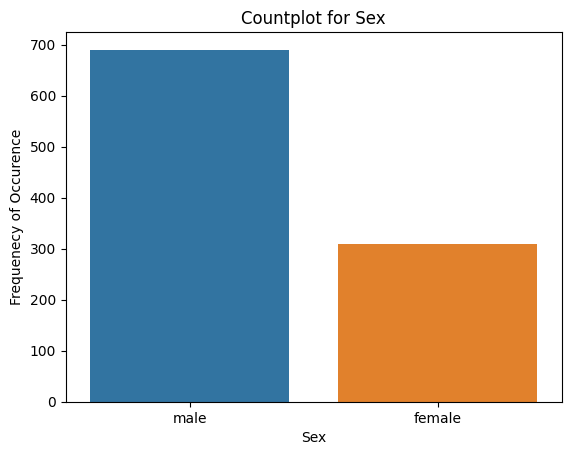

        Value Distribution
male      690        69.0%
female    310        31.0%


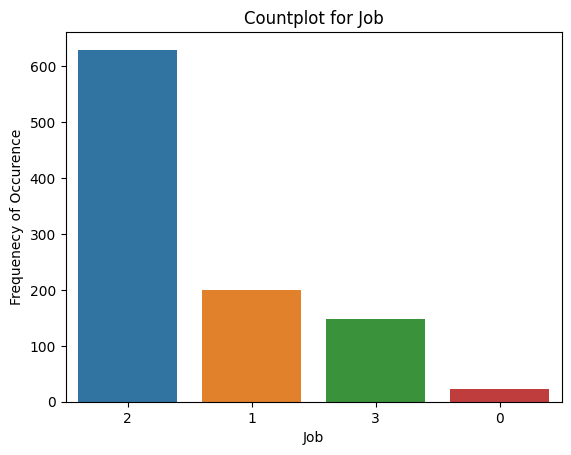

   Value Distribution
2    630        63.0%
1    200        20.0%
3    148        14.8%
0     22         2.2%


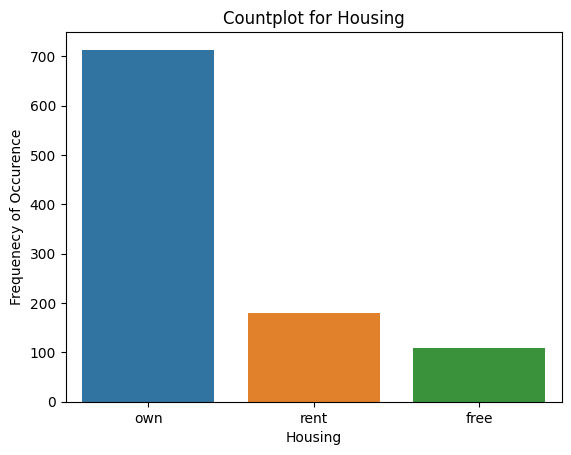

      Value Distribution
own     713        71.3%
rent    179        17.9%
free    108        10.8%


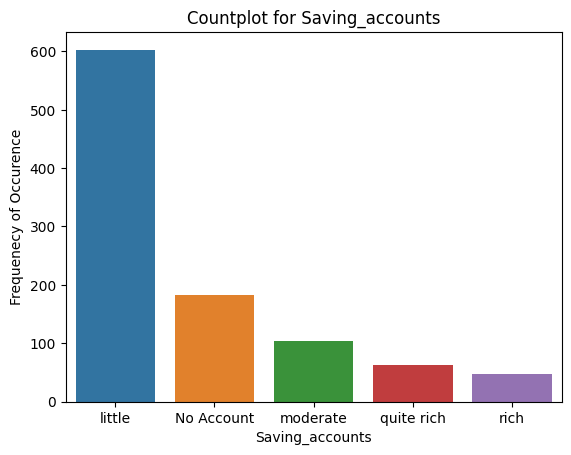

            Value Distribution
little        603        60.3%
No Account    183        18.3%
moderate      103        10.3%
quite rich     63         6.3%
rich           48         4.8%


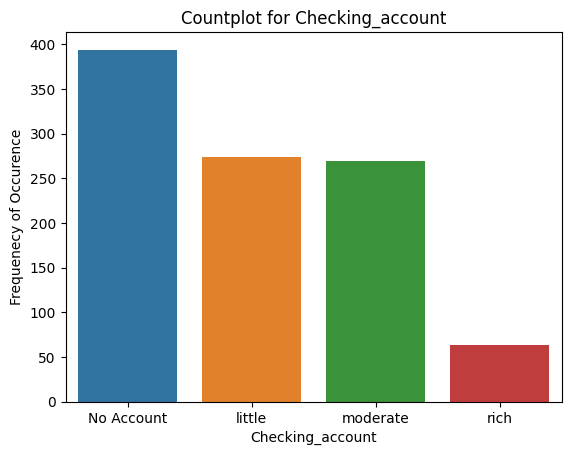

            Value Distribution
No Account    394        39.4%
little        274        27.4%
moderate      269        26.9%
rich           63         6.3%


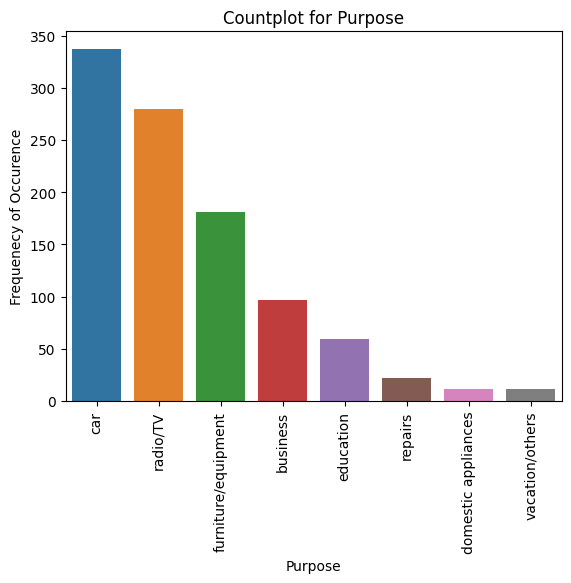

                     Value Distribution
car                    337        33.7%
radio/TV               280        28.0%
furniture/equipment    181        18.1%
business                97         9.7%
education               59         5.9%
repairs                 22         2.2%
domestic appliances     12         1.2%
vacation/others         12         1.2%


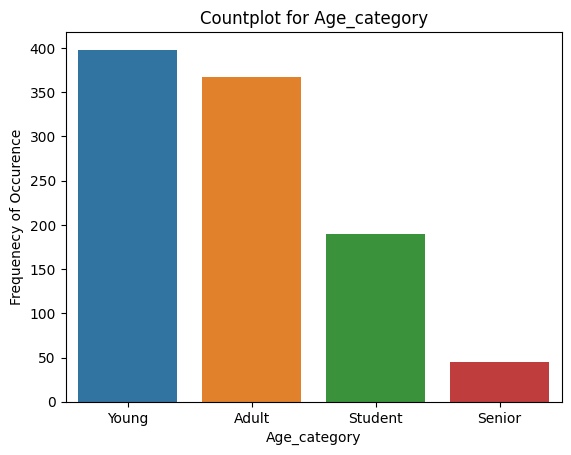

         Value Distribution
Young      398        39.8%
Adult      367        36.7%
Student    190        19.0%
Senior      45         4.5%


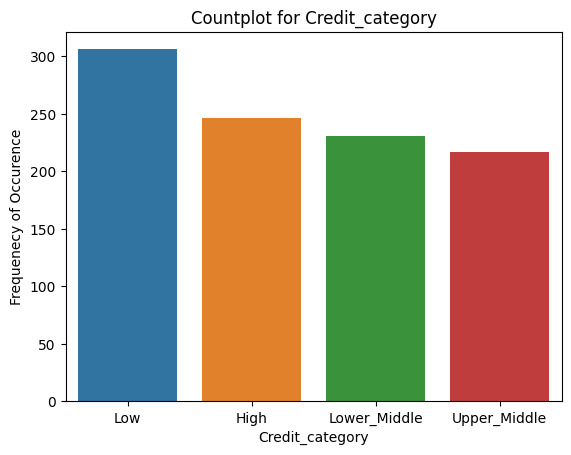

              Value Distribution
Low             306        30.6%
High            246        24.6%
Lower_Middle    231        23.1%
Upper_Middle    217        21.7%


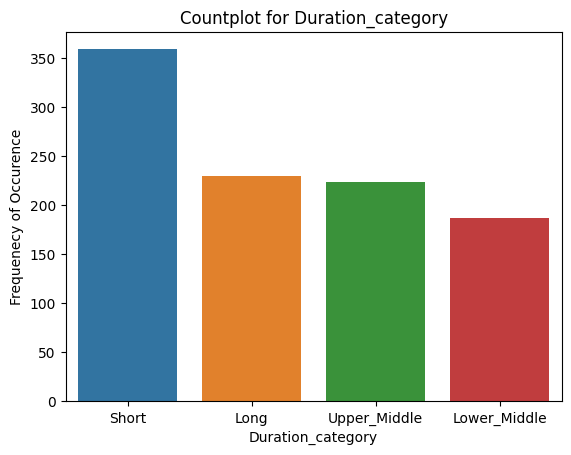

              Value Distribution
Short           359        35.9%
Long            230        23.0%
Upper_Middle    224        22.4%
Lower_Middle    187        18.7%


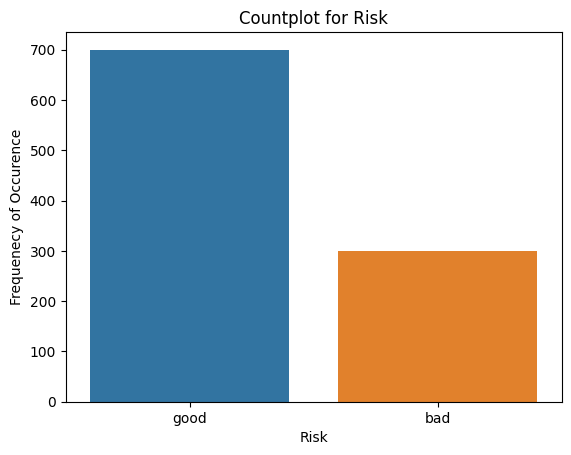

      Value Distribution
good    700        70.0%
bad     300        30.0%


In [14]:
for column in categorical:
    if column=="Purpose":
        count(column,90)
    else:
        count(column)

In [15]:
#Fungsi untuk memplot distribusi fitur berkelanjutan
def hist(column,bins=20):
    sns.histplot(x=column,data=df,bins=bins, color='deepskyblue',kde=True)
    plt.show()

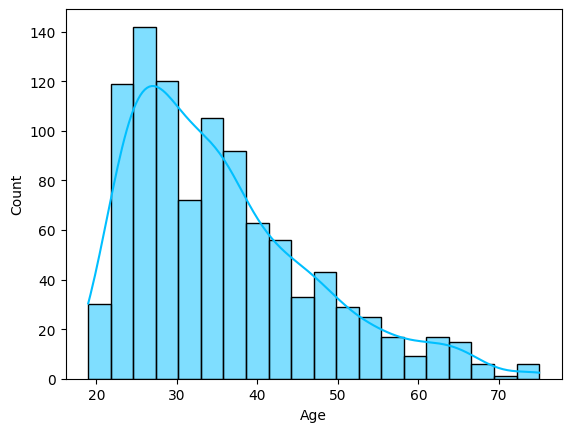

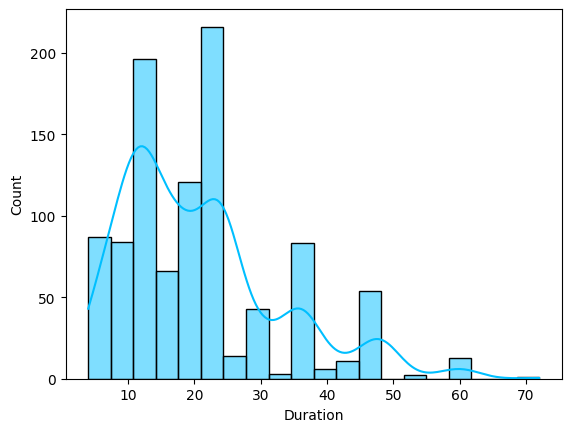

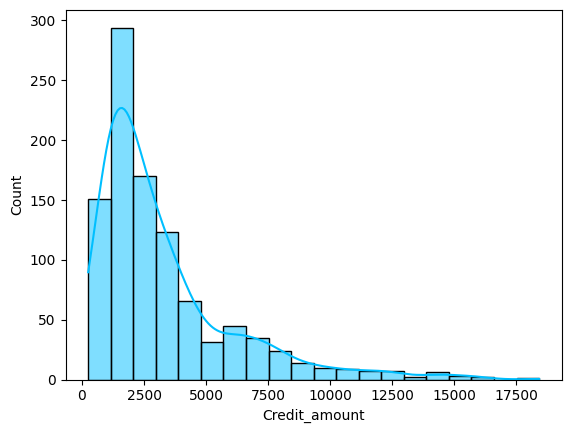

In [16]:
num_columns = ["Age","Duration","Credit_amount"]
for column in num_columns:
    hist(column)

Pada ketiga fitur tersebut distribusi memiliki Skewed Positive

**Multivariete Analysis**

---
Melihat hubungan antara fitur kategorikal dengan risiko kegagalan pembayaran

In [17]:
#Memeriksa berbagai kolom kategori sambil membandingkan dengan kelas target
def bivariate(column,rot=0):
    sns.countplot(x=column, hue="Risk", data=df)
    plt.xticks(rotation=rot)
    plt.show()
    for cat in df[column].unique():
        x = len(df[(df[col]==cat) & (df['Risk']=='bad')])/len(df[(df[col]==cat)])*100
        print(f"Percentage of {cat} with Bad Loans: {x:.2f}%")

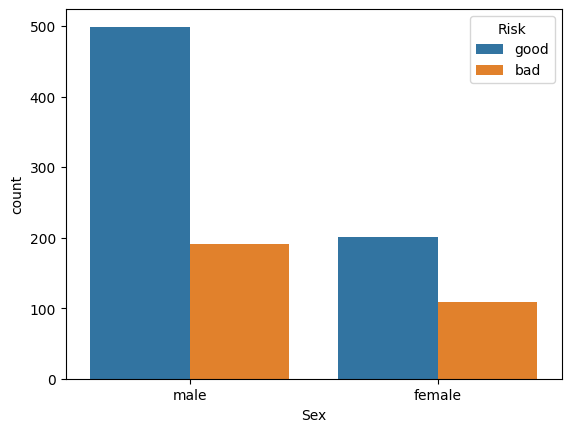

Percentage of male with Bad Loans: 27.68%
Percentage of female with Bad Loans: 35.16%


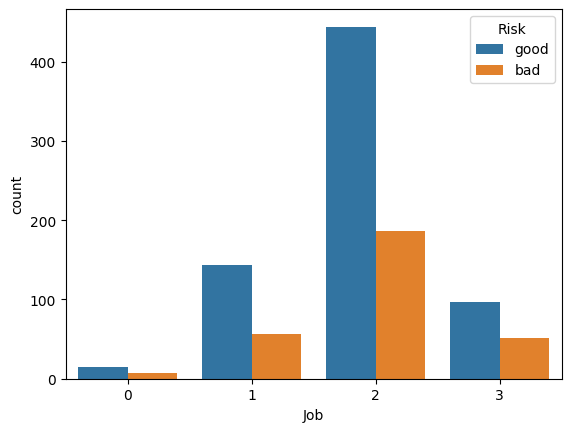

Percentage of 2 with Bad Loans: 29.52%
Percentage of 1 with Bad Loans: 28.00%
Percentage of 3 with Bad Loans: 34.46%
Percentage of 0 with Bad Loans: 31.82%


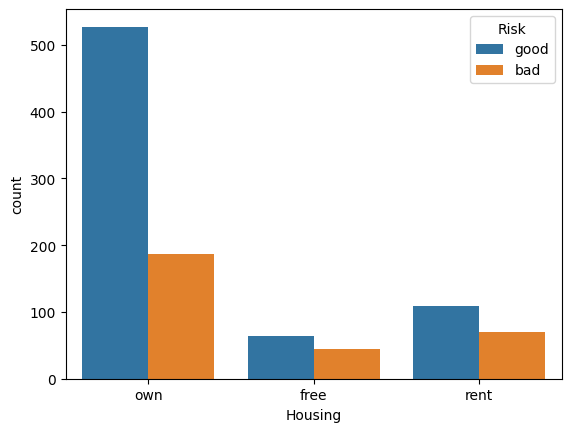

Percentage of own with Bad Loans: 26.09%
Percentage of free with Bad Loans: 40.74%
Percentage of rent with Bad Loans: 39.11%


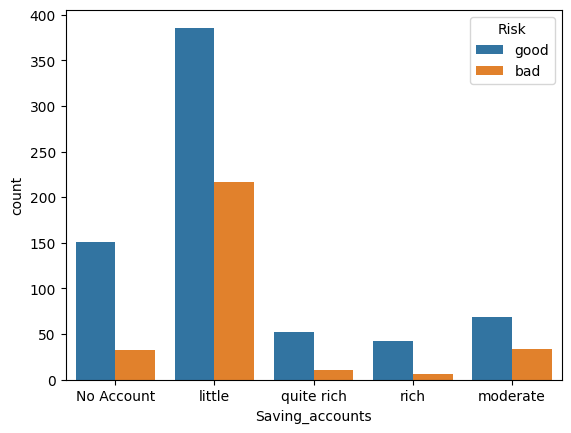

Percentage of No Account with Bad Loans: 17.49%
Percentage of little with Bad Loans: 35.99%
Percentage of quite rich with Bad Loans: 17.46%
Percentage of rich with Bad Loans: 12.50%
Percentage of moderate with Bad Loans: 33.01%


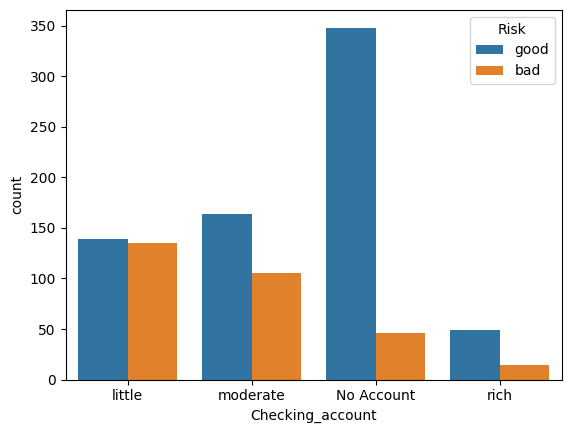

Percentage of little with Bad Loans: 49.27%
Percentage of moderate with Bad Loans: 39.03%
Percentage of No Account with Bad Loans: 11.68%
Percentage of rich with Bad Loans: 22.22%


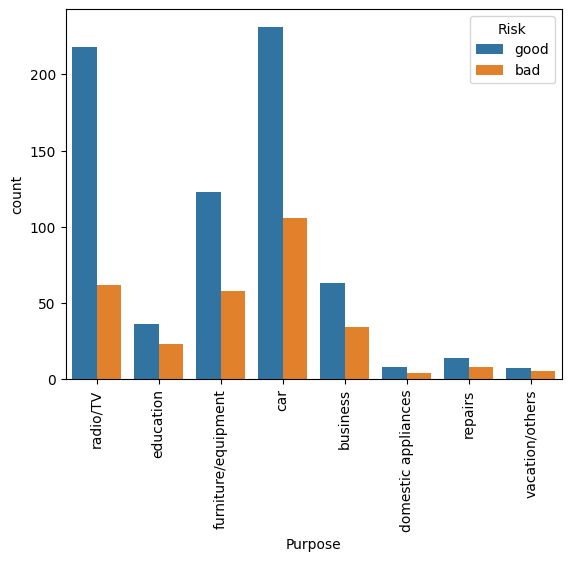

Percentage of radio/TV with Bad Loans: 22.14%
Percentage of education with Bad Loans: 38.98%
Percentage of furniture/equipment with Bad Loans: 32.04%
Percentage of car with Bad Loans: 31.45%
Percentage of business with Bad Loans: 35.05%
Percentage of domestic appliances with Bad Loans: 33.33%
Percentage of repairs with Bad Loans: 36.36%
Percentage of vacation/others with Bad Loans: 41.67%


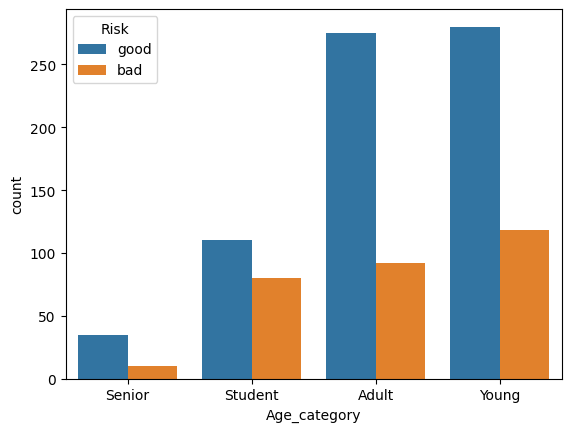

Percentage of Senior with Bad Loans: 22.22%
Percentage of Student with Bad Loans: 42.11%
Percentage of Adult with Bad Loans: 25.07%
Percentage of Young with Bad Loans: 29.65%


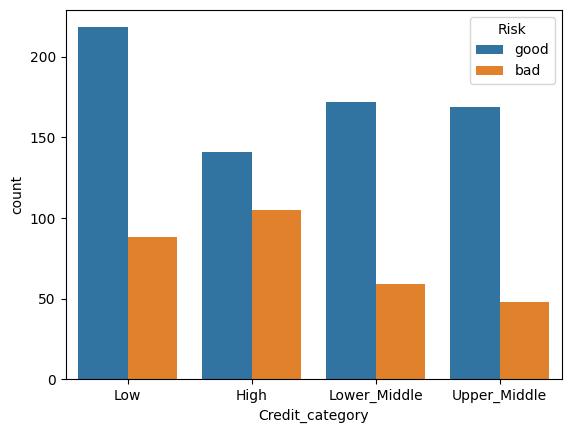

Percentage of Low with Bad Loans: 28.76%
Percentage of High with Bad Loans: 42.68%
Percentage of Lower_Middle with Bad Loans: 25.54%
Percentage of Upper_Middle with Bad Loans: 22.12%


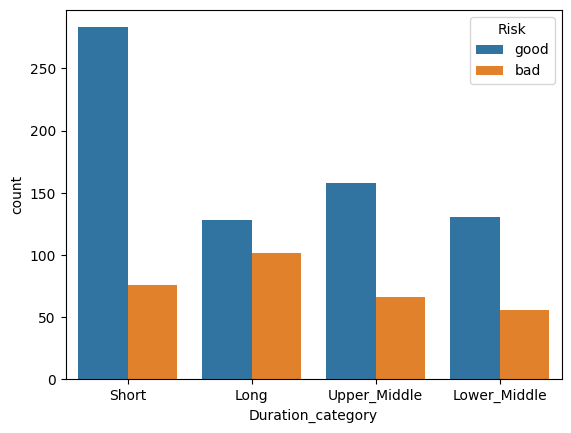

Percentage of Short with Bad Loans: 21.17%
Percentage of Long with Bad Loans: 44.35%
Percentage of Upper_Middle with Bad Loans: 29.46%
Percentage of Lower_Middle with Bad Loans: 29.95%


In [18]:
for col in categorical:
    if col == "Risk":
        pass
    elif col == "Purpose":
        bivariate(col,90)
    else:
        bivariate(col)

**Descriptive Statistics**

---
Analisis deskriptif membantu mendeteksi adanya outlier, serta membantu kita mengidentifikasi adanya dugaan asosiasi pada variabel.

<Axes: xlabel='Credit_amount', ylabel='Purpose'>

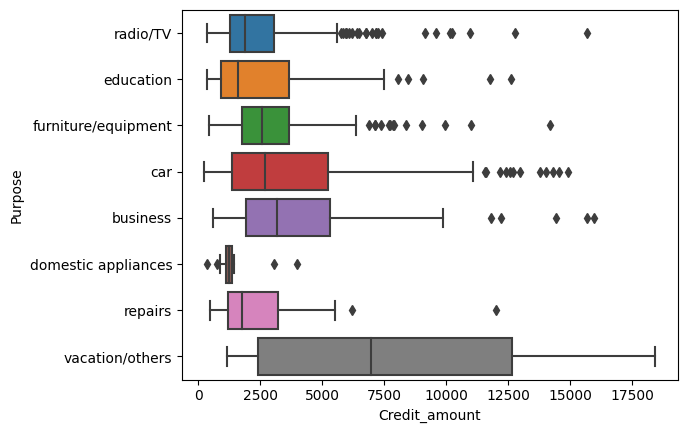

In [19]:
sns.boxplot(y="Purpose",x="Credit_amount",data=df)

In [20]:
#Di sini kami menganalisis outlier jumlah kredit untuk kategori dalam fitur tujuan
def outlier_analysis(cat):
    df_a = df["Credit_amount"].loc[df["Purpose"]==cat]
    out_l = df_a.quantile(0.75) + 1.5*(df_a.quantile(0.75) - df_a.quantile(0.25))
    df_b = df[(df["Purpose"]==cat) & (df["Credit_amount"]>out_l)]
    display(df_b)
    percent = len(df_b.loc[df_b["Risk"]=="bad"])*100/len(df_b)
    print(f"Percentage of Bad Loans for {cat} where the credit amount lies in the oulier range: {percent:.2f}%")

In [21]:
outlier_analysis("radio/TV")

,Age,Sex,Job,Housing,Saving_accounts,Checking_account,Credit_amount,Duration,Purpose,Risk,Age_category,Credit_category,Duration_category
1,22,female,2,own,little,moderate,5951,48,radio/TV,bad,Student,High,Long
56,52,male,3,own,No Account,moderate,6468,12,radio/TV,bad,Adult,High,Short
57,31,female,2,own,little,No Account,9566,36,radio/TV,good,Young,High,Long
80,44,female,2,own,No Account,No Account,5943,24,radio/TV,bad,Adult,High,Upper_Middle
116,30,female,3,own,No Account,little,7174,42,radio/TV,bad,Young,High,Long
134,21,female,2,own,moderate,No Account,10144,60,radio/TV,good,Student,High,Long
152,24,male,2,own,little,rich,5848,36,radio/TV,good,Student,High,Long
226,27,male,2,own,rich,moderate,10961,48,radio/TV,bad,Young,High,Long
255,27,male,1,own,No Account,moderate,7418,60,radio/TV,good,Young,High,Long
353,28,male,2,rent,little,little,6199,12,radio/TV,bad,Young,High,Short


Percentage of Bad Loans for radio/TV where the credit amount lies in the oulier range: 34.78%


In [22]:
outlier_analysis("car")

,Age,Sex,Job,Housing,Saving_accounts,Checking_account,Credit_amount,Duration,Purpose,Risk,Age_category,Credit_category,Duration_category
18,44,female,3,free,little,moderate,12579,24,car,bad,Adult,High,Upper_Middle
236,23,male,0,own,No Account,moderate,14555,6,car,bad,Student,High,Short
272,36,male,3,free,No Account,moderate,12169,48,car,good,Adult,High,Long
333,24,female,1,rent,moderate,No Account,11590,48,car,bad,Student,High,Long
373,63,male,3,free,No Account,No Account,13756,60,car,good,Senior,High,Long
378,57,male,3,free,little,moderate,14318,36,car,bad,Adult,High,Long
381,38,female,3,free,little,moderate,12976,18,car,bad,Adult,High,Lower_Middle
563,37,male,2,free,No Account,moderate,12389,36,car,bad,Adult,High,Long
714,27,male,3,own,little,moderate,14027,60,car,bad,Young,High,Long
736,23,female,3,rent,little,moderate,11560,24,car,bad,Student,High,Upper_Middle


Percentage of Bad Loans for car where the credit amount lies in the oulier range: 83.33%


Dari sini kita bisa melihat ketika orang mengambil jumlah kredit yang berada di kisaran outlier untuk tujuan tertentu seperti pembelian **Mobil atau Furnitur** memiliki ketimpangan mencapai 60-80% sementara untuk beberapa tujuan seperti pembelian **Radio/TV atau Pendidikan** masih berada diantara nilai yang sama.

In [23]:
#Crosstab plot untuk melihat tujuan apa yang dipinjamkan oleh setiap jenis kelamin
date_int = ["Purpose", 'Sex']
pd.crosstab(df[date_int[0]], df[date_int[1]]).style.background_gradient(cmap = "viridis")

Sex,female,male
Purpose,,
business,19,78
car,94,243
domestic appliances,6,6
education,24,35
furniture/equipment,74,107
radio/TV,85,195
repairs,5,17
vacation/others,3,9


Dari crosstab plot kita melihat bahwa **lebih banyak perempuan mengambil pinjaman untuk pendidikan** daripada laki-laki dan **lebih banyak laki-laki mengambil pinjaman untuk mobil daripada perempuan**.

**Correlation b/w variables**

---
Matriks Korelasi untuk Variabel Kontinu

In [24]:
#Replace good/bad with 0/1
df['Risk'] = df['Risk'].replace({'bad': 0, 'good': 1})

<Axes: >

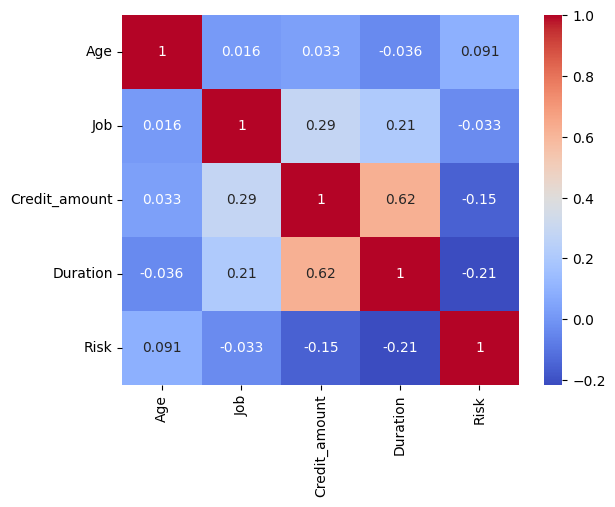

In [25]:
#Correlation Matrix for Continous Variables
corr_matrix = df.corr()
sns.heatmap(corr_matrix, cmap='coolwarm', annot=True)

In [26]:
#Chi-Squared-tes untuk menemukan apakah ada korelasi antara fitur risk dan kategori
def target_corr(col):
    contingency_table = pd.crosstab(df['Risk'], df[col])
    chi2, p_value, dof, expected_freq = chi2_contingency(contingency_table)
    if(p_value>0.05):
        print(f"No correlation b/w the target variable and {col}")
    else:
        print(f"Significant correlation b/w target and {col}")
        print(p_value)

In [27]:
#Hasil untuk berbagai fitur
for col in categorical:
    if col == "Risk":
        pass
    else:
        target_corr(col)

Significant correlation b/w target and Sex
0.020739913068713305
No correlation b/w the target variable and Job
Significant correlation b/w target and Housing
0.00011167465374597684
Significant correlation b/w target and Saving_accounts
2.761214238568249e-07
Significant correlation b/w target and Checking_account
1.2189020722893755e-26
No correlation b/w the target variable and Purpose
Significant correlation b/w target and Age_category
0.00029662487120419244
Significant correlation b/w target and Credit_category
4.256611165020452e-06
Significant correlation b/w target and Duration_category
7.836442057725616e-08


In [28]:
#Chi-Squared-test untuk menemukan korelasi antara fitur kategori independen
def multi_corr(col1,col2):
    contingency_table = pd.crosstab(df[col1], df[col2])
    chi2, p_value, dof, expected_freq = chi2_contingency(contingency_table)
    if(p_value>0.05):
        print(f"No correlation b/w the {col1} and {col2}")
    else:
        print(f"Significant correlation {col1} and {col2}")

In [29]:
#Results
multi_corr('Sex','Housing')
multi_corr('Housing','Checking_account')
multi_corr('Housing','Saving_accounts')
multi_corr("Saving_accounts","Checking_account")
multi_corr('Age_category','Sex')
multi_corr('Age_category','Checking_account')
multi_corr('Age_category','Housing')
multi_corr('Credit_category','Sex')
multi_corr('Credit_category','Checking_account')
multi_corr('Credit_category','Saving_accounts')
multi_corr('Credit_category','Housing')
multi_corr('Duration_category','Saving_accounts')

Significant correlation Sex and Housing
Significant correlation Housing and Checking_account
No correlation b/w the Housing and Saving_accounts
Significant correlation Saving_accounts and Checking_account
Significant correlation Age_category and Sex
Significant correlation Age_category and Checking_account
Significant correlation Age_category and Housing
Significant correlation Credit_category and Sex
Significant correlation Credit_category and Checking_account
No correlation b/w the Credit_category and Saving_accounts
Significant correlation Credit_category and Housing
No correlation b/w the Duration_category and Saving_accounts


**Melakukan one hot encoding**

---
Melakukan one hot encoding pada seluruh data kategorikal

In [30]:
#One-Hot Encoding the Sex and Checking Account
one_hot = pd.get_dummies(df, columns=['Sex', 'Checking_account', 'Age_category', 'Credit_category', 'Duration_category'])

In [31]:
#Dropping columns which are not correlated with target or significantly correlated with some other feature
one_hot = one_hot.drop(['Housing', 'Purpose', 'Saving_accounts'], axis=1)
#Log Transforming the continous variables
one_hot['Duration'] = np.log(one_hot['Duration'])
one_hot['Credit_amount'] = np.log(one_hot['Credit_amount'])
one_hot['Age'] = np.log(one_hot['Age'])

**Cek data setelah one hot encoding**

---
Melihat 5 data pertama setelah melakukan one-hot-encoding

In [32]:
one_hot.head()

,Age,Job,Credit_amount,Duration,Risk,Sex_female,Sex_male,Checking_account_No Account,Checking_account_little,Checking_account_moderate,...,Age_category_Student,Age_category_Young,Credit_category_High,Credit_category_Low,Credit_category_Lower_Middle,Credit_category_Upper_Middle,Duration_category_Long,Duration_category_Lower_Middle,Duration_category_Short,Duration_category_Upper_Middle
0,4.204693,2,7.063904,1.791759,1,0,1,0,1,0,...,0,0,0,1,0,0,0,0,1,0
1,3.091042,2,8.691315,3.871201,0,1,0,0,0,1,...,1,0,1,0,0,0,1,0,0,0
2,3.891820,1,7.647786,2.484907,1,0,1,1,0,0,...,0,0,0,0,1,0,0,0,1,0
3,3.806662,2,8.972337,3.737670,1,0,1,0,1,0,...,0,0,1,0,0,0,1,0,0,0
4,3.970292,2,8.490849,3.178054,0,0,1,0,1,0,...,0,0,1,0,0,0,0,0,0,1


In [33]:
one_hot.describe()

,Age,Job,Credit_amount,Duration,Risk,Sex_female,Sex_male,Checking_account_No Account,Checking_account_little,Checking_account_moderate,...,Age_category_Student,Age_category_Young,Credit_category_High,Credit_category_Low,Credit_category_Lower_Middle,Credit_category_Upper_Middle,Duration_category_Long,Duration_category_Lower_Middle,Duration_category_Short,Duration_category_Upper_Middle
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,...,1000.000000,1000.00000,1000.000000,1000.00000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,3.524306,1.904000,7.788691,2.877018,0.700000,0.310000,0.690000,0.394000,0.274000,0.269000,...,0.190000,0.39800,0.246000,0.30600,0.231000,0.217000,0.230000,0.187000,0.359000,0.224000
std,0.299747,0.653614,0.776474,0.582240,0.458487,0.462725,0.462725,0.488879,0.446232,0.443662,...,0.392497,0.48973,0.430894,0.46106,0.421683,0.412409,0.421043,0.390107,0.479947,0.417131
min,2.944439,0.000000,5.521461,1.386294,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.00000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.295837,2.000000,7.219276,2.484907,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.00000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,3.496508,2.000000,7.749107,2.890372,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,...,0.000000,0.00000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,3.737670,2.000000,8.287088,3.178054,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.000000,1.00000,0.000000,1.00000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
max,4.317488,3.000000,9.821409,4.276666,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.00000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


# Modeling

In [34]:
# Memisahkan fitur dan vektor target
one_hot = one_hot.reindex(columns=[col for col in one_hot.columns if col != 'Risk'] + ['Risk'])
X = one_hot.iloc[:,:-1]
y = one_hot.iloc[:,-1]

In [35]:
one_hot

,Age,Job,Credit_amount,Duration,Sex_female,Sex_male,Checking_account_No Account,Checking_account_little,Checking_account_moderate,Checking_account_rich,...,Age_category_Young,Credit_category_High,Credit_category_Low,Credit_category_Lower_Middle,Credit_category_Upper_Middle,Duration_category_Long,Duration_category_Lower_Middle,Duration_category_Short,Duration_category_Upper_Middle,Risk
0,4.204693,2,7.063904,1.791759,0,1,0,1,0,0,...,0,0,1,0,0,0,0,1,0,1
1,3.091042,2,8.691315,3.871201,1,0,0,0,1,0,...,0,1,0,0,0,1,0,0,0,0
2,3.891820,1,7.647786,2.484907,0,1,1,0,0,0,...,0,0,0,1,0,0,0,1,0,1
3,3.806662,2,8.972337,3.737670,0,1,0,1,0,0,...,0,1,0,0,0,1,0,0,0,1
4,3.970292,2,8.490849,3.178054,0,1,0,1,0,0,...,0,1,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,3.433987,1,7.459339,2.484907,1,0,1,0,0,0,...,1,0,0,1,0,0,0,1,0,1
996,3.688879,3,8.257645,3.401197,0,1,0,1,0,0,...,0,0,0,0,1,1,0,0,0,1
997,3.637586,2,6.689599,2.484907,0,1,1,0,0,0,...,0,0,1,0,0,0,0,1,0,1
998,3.135494,2,7.520235,3.806662,0,1,0,1,0,0,...,0,0,0,1,0,1,0,0,0,0


In [36]:
#Oversampling menggunakan SMOTE
from imblearn.over_sampling import SMOTE
oversample = SMOTE()
X_smote, y_smote = oversample.fit_resample(X, y)

In [37]:
#Train test split
X_train, X_test, y_train, y_test = train_test_split(X_smote,y_smote,test_size=0.2,random_state=4)
X_train.shape, X_test.shape

((1120, 22), (280, 22))

LGR: 0.756184 (0.056112)
LDA: 0.801011 (0.059411)
KNN: 0.697158 (0.059063)
CART: 0.701042 (0.064593)
NB: 0.615350 (0.067867)
RF: 0.764029 (0.044715)
SVM: 0.647689 (0.044659)
XGBM: 0.767795 (0.031913)
LGBM: 0.781119 (0.030255)


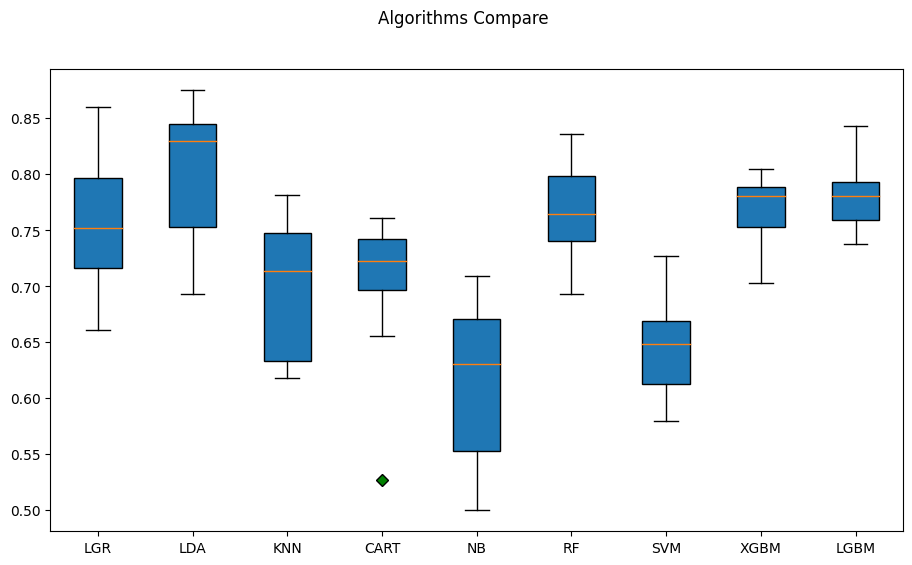

In [38]:
# to feed the random state
seed = 7

# prepare models
models = []
models.append(('LGR', LogisticRegression()))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('RF', RandomForestClassifier()))
models.append(('SVM', SVC(gamma='auto')))
models.append(('XGBM', XGBClassifier()))
models.append(('LGBM', LGBMClassifier()))


# evaluate each model in turn
results = []
names = []
scoring = 'recall'

for name, model in models:
  kfold = KFold(n_splits=10, random_state=seed, shuffle=True)
  cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
  results.append(cv_results)
  names.append(name)
  msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
  print(msg)
        
# boxplot algorithm comparison
fig = plt.figure(figsize=(11,6))
fig.suptitle('Algorithms Compare')
ax = fig.add_subplot(111)
green_diamond = dict(markerfacecolor='g', marker='D')
plt.boxplot(results, flierprops=green_diamond, patch_artist=True)
ax.set_xticklabels(names)
plt.show()

**Linear Discriminant Analysis Model**

---
Melakukan hypertuning parameter dan evaluasi pada Linear Discriminant Model

In [39]:
# model tuning
lda = LinearDiscriminantAnalysis()
# Set the ranges of hyperparameters to optimize
parameters = {
    'solver': ['lsqr'],
    'shrinkage': [None] + [x / 10 for x in range(0, 11)] + ['auto'],
    'n_components': [None] + [1, 2, 5, 8, 13, 21, 34, 55],
    'store_covariance': [True, False],
    'tol': [1e-2, 1e-3, 1e-4, 1e-5, 1e-6, 1e-7, 1e-8, 1e-9, 1e-10, 1e-11, 1e-12, 1e-13, 1e-14, 1e-15]}

#GridSearchCV method
gs_cv = GridSearchCV(lda,
                     parameters,
                     cv=5,                                  # i did cv=5 this is not enough and this is for faster estimate
                     n_jobs=-1,
                     verbose=2).fit(X_train, y_train)

plot_grid_search(gs_cv)
table_grid_search(gs_cv)

#En iyi parametrelerle model kurma
lda_tuned = LinearDiscriminantAnalysis(**gs_cv.best_params_).fit(X, y)
cross_val_score(lda_tuned, X_test, y_test, cv=10).mean()

#cv islemleri(caprazlama)
kfold = KFold(n_splits=10, random_state=123, shuffle=True)
cv_results = cross_val_score(LinearDiscriminantAnalysis(), X_train, y_train, cv=kfold, scoring="accuracy")
cv_results.mean()
gs_cv.best_estimator_

Fitting 5 folds for each of 3276 candidates, totalling 16380 fits


mean_test_score,mean_fit_time,mean_score_time,param_n_components,param_shrinkage,param_solver,param_store_covariance,param_tol
0.767857,0.008141,0.002944,None,None,lsqr,False,0.010000
0.767857,0.008166,0.002690,1,None,lsqr,True,0.000000
0.767857,0.008195,0.002771,1,None,lsqr,False,0.001000
0.767857,0.008240,0.002845,None,0.000000,lsqr,False,0.000010
0.767857,0.008245,0.002583,1,None,lsqr,True,0.000000
0.767857,0.008292,0.002808,None,None,lsqr,False,0.000000
0.767857,0.008308,0.002966,1,None,lsqr,False,0.000100
0.767857,0.008337,0.002819,None,None,lsqr,False,0.001000
0.767857,0.008348,0.002677,1,None,lsqr,True,0.000000
0.767857,0.008362,0.002821,1,None,lsqr,False,0.000000


LinearDiscriminantAnalysis(solver='lsqr', store_covariance=True, tol=0.01)

Primitive error evaluation accuracy score:  0.7848214285714286
Test predict accuracy score:  0.8285714285714286 

Confussion Matrix: 
 [[114  25]
 [ 23 118]] 

Classification report according to Test prediction: 
               precision    recall  f1-score   support

           0       0.83      0.82      0.83       139
           1       0.83      0.84      0.83       141

    accuracy                           0.83       280
   macro avg       0.83      0.83      0.83       280
weighted avg       0.83      0.83      0.83       280



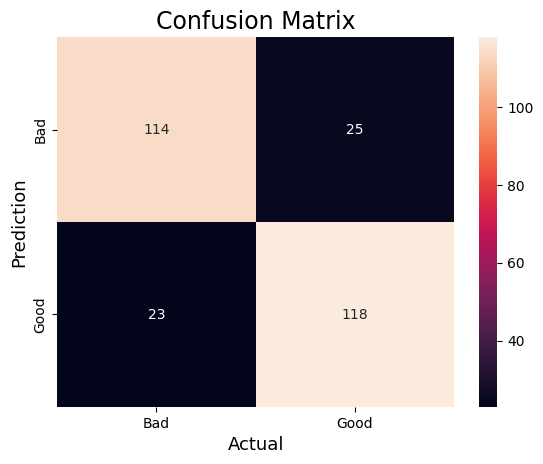

In [40]:
from sklearn.utils import resample
from sklearn.metrics import roc_curve

# Fitting with train data
model = lda_tuned.fit(X_train, y_train)
labels = ['Bad', 'Good']
print("Primitive error evaluation accuracy score: ", model.score(X_train, y_train))

y_pred = model.predict(X_test)

print("Test predict accuracy score: ", accuracy_score(y_test,y_pred),"\n")

print("Confussion Matrix: \n", confusion_matrix(y_test, y_pred),"\n")

print("Classification report according to Test prediction: \n", classification_report(y_test, y_pred))

# Plotting a Confusion Matrix in Seaborn
conf_matrix = confusion_matrix(y_test, y_pred, labels=model.classes_)
sns.heatmap(conf_matrix,
            annot=True,
            fmt='g',
            xticklabels=labels,
            yticklabels=labels,
    )
plt.ylabel('Prediction',fontsize=13)
plt.xlabel('Actual',fontsize=13)
plt.title('Confusion Matrix',fontsize=17)
plt.show()

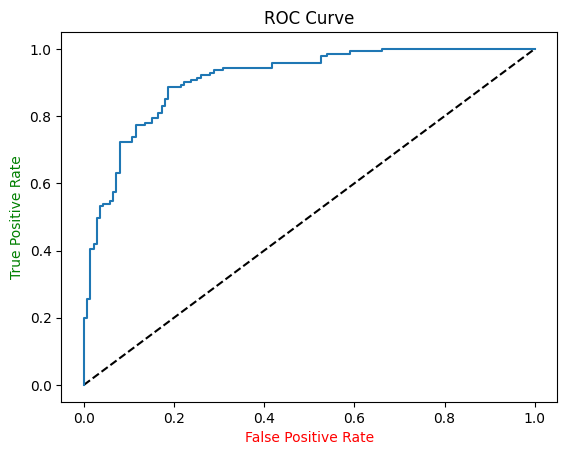

In [41]:
#Predicting proba
y_pred_prob = model.predict_proba(X_test)[:,1]

# Generate ROC curve values: fpr, tpr, thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

# Plot ROC curve
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate', color="r")
plt.ylabel('True Positive Rate', color="g")
plt.title('ROC Curve')
plt.show()

**LightGBM Model**

---
Melakukan hypertuning parameter dan evaluasi pada LightGBM Model

In [42]:
# model tuning

lgbm = LGBMClassifier()
lgbm_params = {"learning_rate": [0.01, 0.03, 0.05, 0.1, 0.5],
               "n_estimators": [500, 1000, 1500],
               "max_depth": [3,5,8]}

#GridSearchCV method
gs_cv = GridSearchCV(lgbm,
                     lgbm_params,
                     cv=5,                                  # i did cv=5 this is not enough and this is for faster estimate
                     n_jobs=-1,
                     verbose=2).fit(X_train, y_train)

plot_grid_search(gs_cv)
table_grid_search(gs_cv)
#En iyi parametrelerle model kurma
lgbm_tuned = LGBMClassifier(**gs_cv.best_params_).fit(X, y)
cross_val_score(lgbm_tuned, X_test, y_test, cv=10).mean()

#cv islemleri(caprazlama)
kfold = KFold(n_splits=10, random_state=123, shuffle=True)
cv_results = cross_val_score(LGBMClassifier(), X_train, y_train, cv=kfold, scoring="accuracy")
cv_results.mean()

Fitting 5 folds for each of 45 candidates, totalling 225 fits


mean_test_score,mean_fit_time,mean_score_time,param_learning_rate,param_max_depth,param_n_estimators
0.780357,0.528569,0.025950,0.010000,5,1000


0.7830357142857143

In [43]:
gs_cv.best_estimator_

LGBMClassifier(learning_rate=0.01, max_depth=5, n_estimators=1000)

Primitive error evaluation accuracy score:  0.8089285714285714
Test predict accuracy score:  0.8214285714285714 

Confussion Matrix: 
 [[ 94  45]
 [  5 136]] 

Classification report according to Test prediction: 
               precision    recall  f1-score   support

           0       0.95      0.68      0.79       139
           1       0.75      0.96      0.84       141

    accuracy                           0.82       280
   macro avg       0.85      0.82      0.82       280
weighted avg       0.85      0.82      0.82       280



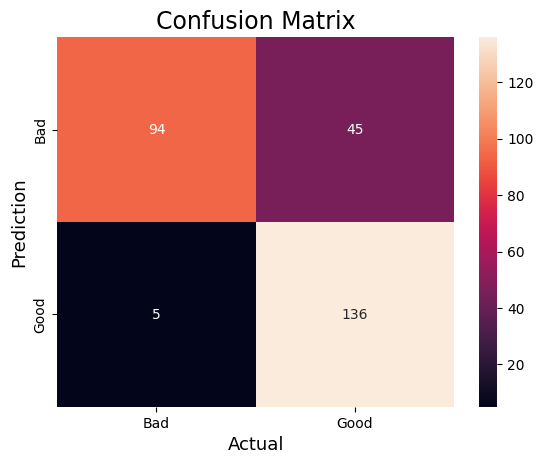

In [44]:
print("Primitive error evaluation accuracy score: ", lgbm_tuned.score(X_train, y_train))

y_pred = lgbm_tuned.predict(X_test)

print("Test predict accuracy score: ", accuracy_score(y_test,y_pred),"\n")

print("Confussion Matrix: \n", confusion_matrix(y_test, y_pred),"\n")

print("Classification report according to Test prediction: \n", classification_report(y_test, y_pred))

# Plotting a Confusion Matrix in Seaborn
conf_matrix = confusion_matrix(y_test, y_pred, labels=lgbm_tuned.classes_)
sns.heatmap(conf_matrix,
            annot=True,
            fmt='g',
            xticklabels=labels,
            yticklabels=labels,
    )
plt.ylabel('Prediction',fontsize=13)
plt.xlabel('Actual',fontsize=13)
plt.title('Confusion Matrix',fontsize=17)
plt.show()

**XGBOOST Model**

---
Melakukan hypertuning parameter dan evaluasi pada XGBOOST Model

In [45]:
xgb = XGBClassifier(random_state = 12345)

xgb_params = {
    "learning_rate": [0.01, 0.1, 0.2, 1],
    "min_samples_split": np.linspace(0.1, 0.5, 10),
    "max_depth":[3,5,8],
    "subsample":[0.5, 0.9, 1.0],
    "n_estimators": [100,1000]}

#xgb_cv_model  = GridSearchCV(xgb,xgb_params, cv = 5, n_jobs = -1, verbose = 2).fit(X, y)    # i did cv=5 this is not enough and this is for faster estimate
#xgb_tuned = XGBClassifier(**xgb_cv_model.best_params_).fit(X,y)
xgb = XGBClassifier().fit(X,y)
cross_val_score(xgb, X, y, cv = 10).mean()

0.7120000000000001

Primitive error evaluation accuracy score:  0.9133928571428571
Test predict accuracy score:  0.9071428571428571 

Confussion Matrix: 
 [[113  26]
 [  0 141]] 

Classification report according to Test prediction: 
               precision    recall  f1-score   support

           0       1.00      0.81      0.90       139
           1       0.84      1.00      0.92       141

    accuracy                           0.91       280
   macro avg       0.92      0.91      0.91       280
weighted avg       0.92      0.91      0.91       280



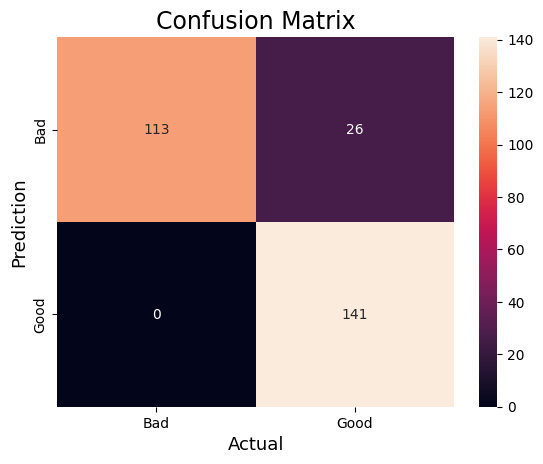

In [46]:
print("Primitive error evaluation accuracy score: ", xgb.score(X_train, y_train))

y_pred = xgb.predict(X_test)

print("Test predict accuracy score: ", accuracy_score(y_test,y_pred),"\n")

print("Confussion Matrix: \n", confusion_matrix(y_test, y_pred),"\n")

print("Classification report according to Test prediction: \n", classification_report(y_test, y_pred))

# Plotting a Confusion Matrix in Seaborn
conf_matrix = confusion_matrix(y_test, y_pred, labels=xgb.classes_)
sns.heatmap(conf_matrix,
            annot=True,
            fmt='g',
            xticklabels=labels,
            yticklabels=labels,
    )
plt.ylabel('Prediction',fontsize=13)
plt.xlabel('Actual',fontsize=13)
plt.title('Confusion Matrix',fontsize=17)
plt.show()

**Kesimpulan**

---
Hasil Modeling risiko kegagalan bayar peminjaman menggunakan **Linear Discriminat Analysis Model**, **LightGBM Model**, dan **XGBOOST Model** menghasilkan model yang lebih baik menggunakan **XGBOOST Model** dengan tingkat akurasi mencapai 90% Dibandingkan dengan yang lainnya. Hal ini menyimpulkan bahwa model yang telah dibangun sudah cukup baik dalam mengenali pattern dari kegagalan bayar dari suatu peminjaman.